In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [61]:
# build the dataset

block_size = 3 #conetxt length
X, Y = [] ,[] 
for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context ), ' ---->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([16, 3]), torch.int64, torch.Size([16]), torch.int64)

In [156]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn((27,2))

In [9]:
emb = C[X]
emb.shape

torch.Size([16, 3, 2])

In [10]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [18]:
h = emb.view(-1,6) @ W1 + b1

#### Some ways to concat the tensor and manipulation

torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape

torch.cat(torch.unbind(emb,1),1).shape

emb.view(16,6) == torch.cat(torch.unbind(emb,1),1)

In [19]:
h

tensor([[ 0.5370, -1.7422,  2.2596,  ...,  2.9222,  0.0118,  2.8488],
        [-0.2491,  1.2543, -0.6650,  ...,  5.9428,  1.2403,  0.4284],
        [ 2.4528, -0.6474, -4.3184,  ...,  4.6260,  0.3323, -1.5940],
        ...,
        [ 0.8958, -0.7074,  1.2403,  ...,  3.0023,  0.0323,  1.8802],
        [-0.2216, -0.3865,  0.3241,  ...,  5.4214,  0.4327, -0.4268],
        [ 1.0605, -1.3668, -0.4317,  ...,  4.1707, -1.7045, -0.3248]])

In [20]:
h.shape

torch.Size([16, 100])

In [21]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [22]:
logits = h @ W2 + b2

In [23]:
logits.shape

torch.Size([16, 27])

In [24]:
counts = logits.exp()

In [25]:
prob = counts/ counts.sum(1,keepdims=True)

In [26]:
prob.shape

torch.Size([16, 27])

In [29]:
loss = -prob[torch.arange(16),Y].log().mean()
loss

tensor(32.0214)

In [30]:
# -------------------- now made respectable ------------

In [223]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [224]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [225]:
sum(p.nelement() for p in parameters)

11897

In [226]:
for p in parameters:
    p.requires_grad = True

In [227]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [228]:
lri = []
lossi = []
stepi = []

In [229]:
for i in range(200000):
    #mini batch construct
    ix = torch.randint(0,Xtr.shape[0],(32,))
   
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
      
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
# print(loss.item())

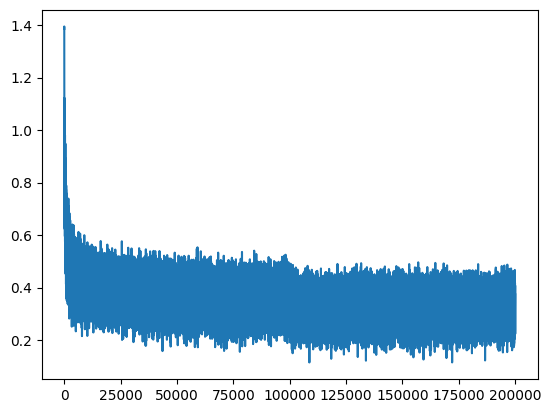

In [230]:
plt.plot(stepi, lossi)

In [231]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1209, grad_fn=<NllLossBackward0>)

In [232]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1630, grad_fn=<NllLossBackward0>)

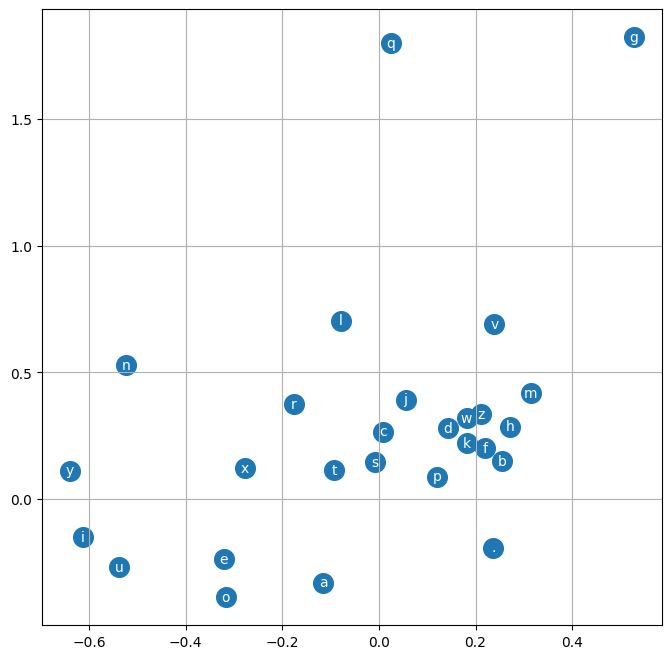

In [216]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [174]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [233]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [234]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
ambril.
khy.
miliathty.
hachanne.
rahnte.
den.
rha.
kaeli.
nellara.
chaiivia.
lege.
halmo.
din.
quinn.
shon.
waira.
bick.
jero.
dearisi.
